# T-Learner

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import utils as utl
from tqdm import tqdm, trange
from time import time

In [2]:
data = pkl.load(open('../data/data.pkl', 'rb'))
data.head(2)

,confidence,index,time,token_path,term_match,word_net,T,Y
0,46.0,16,17.0,14.2148,12.0,11.2946,1,80
1,37.4,16,13.0,14.2148,12.0,11.2946,0,28


## Linear regression

In [3]:
def linear_regression(df, add_model=False, add_R2=False):
    T, NT = df[df['T']==1].copy(), df[df['T']==0].copy()
    T_x = T[T.columns[~T.columns.isin(['T', 'Y'])]]
    NT_x = NT[NT.columns[~NT.columns.isin(['T', 'Y'])]]
    ALL_x = df[df.columns[~df.columns.isin(['T', 'Y'])]]
    
    T_reg = LinearRegression().fit(T_x, T['Y'])
    NT_reg = LinearRegression().fit(NT_x, NT['Y'])
    R2 = (T_reg.score(T_x, T['Y']), NT_reg.score(NT_x, NT['Y']))
        
    returns = [(T_reg.predict(ALL_x) - NT_reg.predict(ALL_x)).mean()]
    if add_model: returns.append((T_reg, NT_reg))
    if add_R2: returns.append(R2)
    return returns if len(returns)>1 else returns[0]

Linear regression (S-Learner) ATE over original data: 12.007361768112835
R2 Score (Treated / Not Treated): (0.0736186816808424, 0.17874108454825155)
MSE T: 817.682923363391
MSE NT: 688.9260477346206


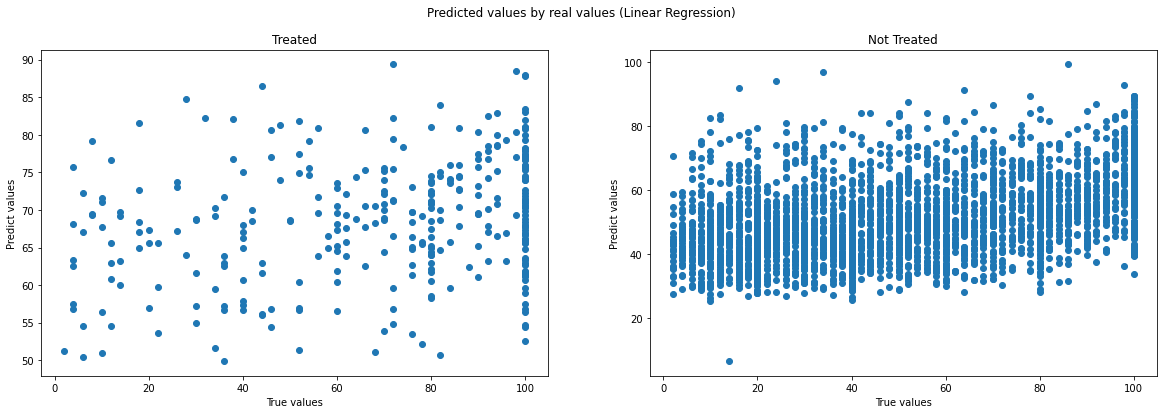

In [4]:
ATE, (T_reg, NT_reg), R2 = linear_regression(data, True, True)
print(f"Linear regression (S-Learner) ATE over original data: {ATE}")
print(f"R2 Score (Treated / Not Treated): {R2}")

T, NT = data[data['T']==1].copy(), data[data['T']==0].copy()
T_x = T[T.columns[~T.columns.isin(['T', 'Y'])]]
NT_x = NT[NT.columns[~NT.columns.isin(['T', 'Y'])]]

T_predictions = T_reg.predict(T_x)
NT_predictions = NT_reg.predict(NT_x)
print(f"MSE T: {((T['Y'] - T_predictions).abs() ** 2).mean()}\nMSE NT: {((NT['Y'] - NT_predictions).abs() ** 2).mean()}")

fix, axes = plt.subplots(1,2, figsize=(20,6))
for i in range(2):
    ax = axes[i]
    ax.scatter(*{0:(T['Y'], T_predictions), 1:(NT['Y'], NT_predictions)}[i])
    ax.set_xlabel("True values")
    ax.set_ylabel("Predict values")
    ax.set_title(f"{'' if not i else 'Not '}Treated")
plt.suptitle("Predicted values by real values (Linear Regression)")
plt.show()

In [5]:
linear_regression_results = utl.generate_CI(data, linear_regression, f_kwargs={}, samples=1000, alpha=0.95)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.06it/s]


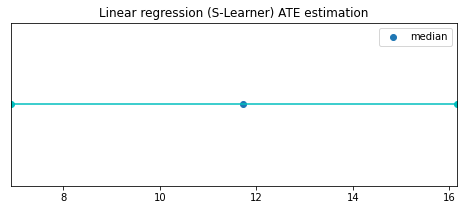

In [6]:
plt.figure(figsize=(8,3))
plot = (
            'm',
            # 'a',
        )
utl.plot_CI(**linear_regression_results, plot=plot, title='Linear regression (S-Learner) ATE estimation', xlim_l=None, xlim_u=None)

## Decision tree

In [7]:
def decision_trees(df, add_model=False, add_R2=False):
    T, NT = df[df['T']==1].copy(), df[df['T']==0].copy()
    T_x = T[T.columns[~T.columns.isin(['T', 'Y'])]]
    NT_x = NT[NT.columns[~NT.columns.isin(['T', 'Y'])]]
    ALL_x = df[df.columns[~df.columns.isin(['T', 'Y'])]]
    
    T_reg =  DecisionTreeRegressor(max_depth=18).fit(T_x, T['Y'])
    NT_reg =  DecisionTreeRegressor(max_depth=18).fit(NT_x, NT['Y'])
    R2 = (T_reg.score(T_x, T['Y']), NT_reg.score(NT_x, NT['Y']))
        
    returns = [(T_reg.predict(ALL_x) - NT_reg.predict(ALL_x)).mean()]
    if add_model: returns.append((T_reg, NT_reg))
    if add_R2: returns.append(R2)
    return returns if len(returns)>1 else returns[0]

Decision tree (S-Learner) ATE over original data: 5.911707327356498
R2 Score (Treated / Not Treated): (0.999937445325957, 0.9530233943497425)
MSE T: 0.05521472392638037
MSE NT: 39.40706963140569


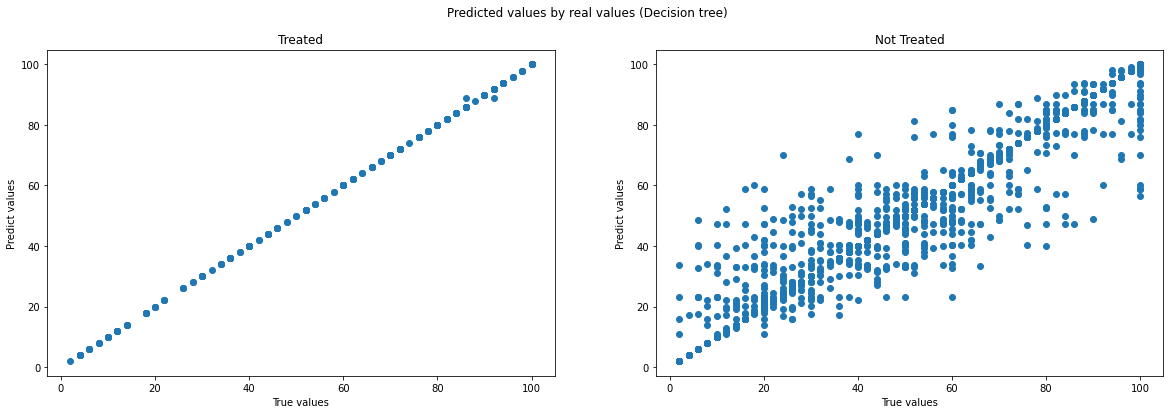

In [8]:
ATE, (T_reg, NT_reg), R2 = decision_trees(data, True, True)
print(f"Decision tree (S-Learner) ATE over original data: {ATE}")
print(f"R2 Score (Treated / Not Treated): {R2}")

T, NT = data[data['T']==1].copy(), data[data['T']==0].copy()
T_x = T[T.columns[~T.columns.isin(['T', 'Y'])]]
NT_x = NT[NT.columns[~NT.columns.isin(['T', 'Y'])]]

T_predictions = T_reg.predict(T_x)
NT_predictions = NT_reg.predict(NT_x)
print(f"MSE T: {((T['Y'] - T_predictions).abs() ** 2).mean()}\nMSE NT: {((NT['Y'] - NT_predictions).abs() ** 2).mean()}")

fix, axes = plt.subplots(1,2, figsize=(20,6))
for i in range(2):
    ax = axes[i]
    ax.scatter(*{0:(T['Y'], T_predictions), 1:(NT['Y'], NT_predictions)}[i])
    ax.set_xlabel("True values")
    ax.set_ylabel("Predict values")
    ax.set_title(f"{'' if not i else 'Not '}Treated")
plt.suptitle("Predicted values by real values (Decision tree)")
plt.show()

In [9]:
decision_tree_results = utl.generate_CI(data, decision_trees, f_kwargs={}, samples=1000, alpha=0.95)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.03it/s]


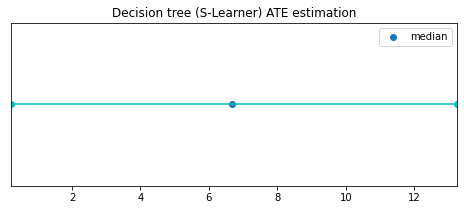

In [10]:
plt.figure(figsize=(8,3))
plot = (
            'm',
            # 'a',
        )
utl.plot_CI(**decision_tree_results, plot=plot, title='Decision tree (S-Learner) ATE estimation', xlim_l=None, xlim_u=None)

## Saving

In [11]:
save = True
saving_list = [(linear_regression_results, 'LR T-learner'), (decision_tree_results, 'DT T-learner'),]
if save:
    for var, name in saving_list:
        pkl.dump(var, open(f'../results/{name}', 'wb'))